kernel rapids

# Figure 2

## Fig 2e Generate tSNE Xenium All Cell Types

In [80]:
import scanpy as sc
import rapids_singlecell as rsc
import cupy as cp
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import LinearSegmentedColormap
from pandas.api.types import CategoricalDtype
from scipy.cluster.hierarchy import fcluster
import json
import pandas as pd

In [74]:
# Keep text editable
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
from cuml.manifold import TSNE

In [4]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [ ]:
data_path = '../input_data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_2/'

In [6]:
data = sc.read_h5ad(data_path)

In [7]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

In [8]:
plot_data = ad.AnnData(
    X=data.obsm['X_vitmae_finetuned_img_features'],
    obs=data.obs,
)

In [9]:
sc.pp.scale(plot_data)

In [10]:
rsc.get.anndata_to_GPU(plot_data)

In [11]:
rsc.pp.pca(plot_data, n_comps=100)

[2025-08-24 14:05:59.275] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [12]:
rsc.tl.tsne(
    plot_data,
    n_pcs=100,
    perplexity=30,
    early_exaggeration=12,
    learning_rate=200,
)

[2025-08-24 14:06:00.164] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [13]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = 17
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [14]:
np.save(f'{out_dir}tsne_colors_no_unassigned_impr.npy', palette)

In [15]:
order = [
    'Tumor Cells',
    'Tumor Associated Endothelial Cells',
    'Pericytes',
    'SOX2-OT+ Tumor Cells',
    'Fallopian Tube Epithelium',
    'Smooth Muscle Cells',
    'Tumor Associated Fibroblasts',
    'Inflammatory Tumor Cells',
    'Macrophages',
    'Malignant Cells Lining Cyst',
    'T and NK Cells',
    'Ciliated Epithelial Cells',
    'Stromal Associated Fibroblasts',
    'Granulosa Cells',
    'Proliferative Tumor Cells',
    # 'Unassigned',
    'Stromal Associated Endothelial Cells',
    'VEGFA+ Tumor Cells',
]
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(order)}

# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(plot_data.obs['10X_cell_type'].cat.categories)
plot_data.uns['10X_cell_type_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

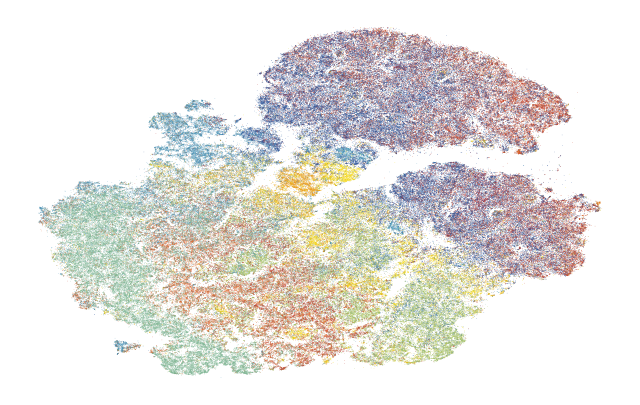

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

sc.pl.tsne(
    plot_data[plot_data.obs['10X_cell_type'] != 'Unassigned'],
    color = '10X_cell_type',
    ax = ax,
    s = 0.5,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_2e.png', dpi=600, bbox_inches='tight',)

In [88]:
pd.DataFrame(
    {
        'cell_id': plot_data.obs['cell_id'],
        'cell_label': plot_data.obs['cell_labels'],
        '10X_cell_type': plot_data.obs['10X_cell_type'],
        'tsne_x': plot_data.obsm['X_tsne'][:,0],
        'tsne_y': plot_data.obsm['X_tsne'][:,1],
    }
).to_csv(f'{out_dir}all_cells_tsne.csv', index=False)

## Fig 2f Macrophages

In [17]:
plot_macs = plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'].copy()

In [18]:
rsc.pp.scale(plot_macs)

In [19]:
rsc.pp.neighbors(plot_macs, n_neighbors=5, use_rep='X')

In [20]:
rsc.tl.leiden(plot_macs, resolution=0.8, key_added='vitmae_leiden_macs')

In [21]:
# Convert Leiden cluster names to 1-based index
plot_macs.obs['vitmae_leiden_macs'] = plot_macs.obs['vitmae_leiden_macs'].astype(int).add(1).astype(str).astype('category')
groups_to_plot = ['11', '4', '12', '8', '9', '13', '1', '10']

In [22]:
merged_obs = plot_data.obs.merge(
    plot_macs.obs[['cell_id', 'vitmae_leiden_macs']],
    right_on='cell_id',
    left_on='cell_id',
    how='left'
)
plot_data.obs = merged_obs

In [90]:
# Save Leiden Clusters
plot_data.obs[['cell_id', 'vitmae_leiden_macs']].to_csv(f'{out_dir}macrophage_image_leiden.csv', index=False)

In [23]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = 8
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [24]:
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(groups_to_plot)}
# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(plot_data.obs['vitmae_leiden_macs'].cat.categories)
plot_data.uns['vitmae_leiden_macs_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

In [75]:
with open(f"{out_dir}cluster_to_color.json", "w") as f:
    json.dump(cluster_to_color, f)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


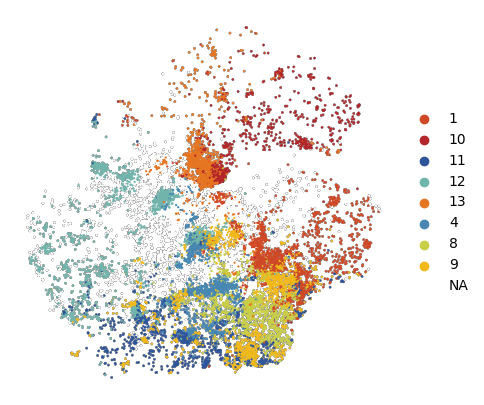

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    s = 10,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
    # legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_2f.png', dpi=600, bbox_inches='tight',)

In [26]:
rsc.pp.neighbors(plot_data, n_neighbors=15)
rsc.tl.umap(plot_data)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


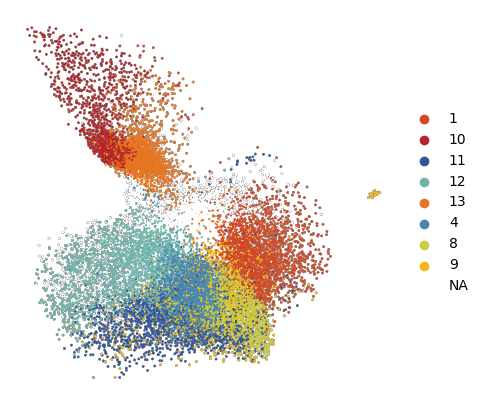

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    s = 10,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


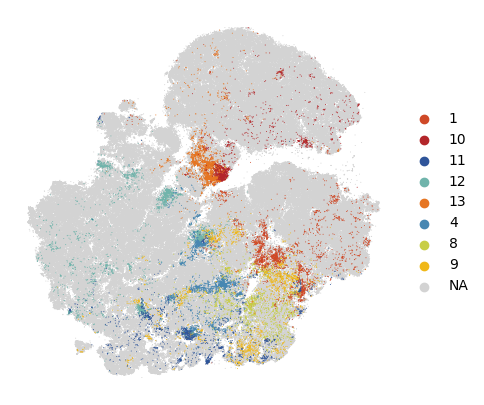

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data,
    color = 'vitmae_leiden_macs',
    ax = ax,
    s = 2,
    alpha = 1,
    frameon=False,
    title='',
    na_color='lightgrey',
    groups=groups_to_plot,
)

## Fig 2h Map Macrophages onto Tissue

In [68]:
macs_clusters = plot_data.obs[plot_data.obs['10X_cell_type'] == 'Macrophages'][['cell_id','vitmae_leiden_macs']].copy()

In [69]:
macs_clusters['Has_DE_Genes'] = macs_clusters['vitmae_leiden_macs'].isin(groups_to_plot)

In [70]:
macs_clusters.to_csv(f'{out_dir}macs_clusters.csv', index=False)

## Fig 2i Differentially Expressed Genes between Macrophage Leiden Clusters

In [29]:
data_genes = data.copy()

In [30]:
merged_obs = data_genes.obs.merge(
    plot_macs.obs[['cell_id', 'vitmae_leiden_macs']],
    right_on='cell_id',
    left_on='cell_id',
    how='left'
)
data_genes.obs = merged_obs

In [31]:
data_genes_macs = data_genes[data_genes.obs['cell_type'] == 'Macrophages'].copy()

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
sc.pp.normalize_total(data_genes_macs, target_sum=10e4)

log1p is necessary here, because DE gene analysis is sensitive to high-variance outlier genes. In contrast to embedding into SCimilarity, the absolute range of values does not matter here.

In [33]:
sc.pp.log1p(data_genes_macs)

In [34]:
sc.pp.pca(data_genes_macs)

In [35]:
sc.tl.rank_genes_groups(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    method="wilcoxon"
)

In [36]:
sc.tl.dendrogram(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
)

In [37]:
data_genes_macs.uns['rank_genes_groups']['pvals_adj']

rec.array([(0.00000000e+000, 4.17700315e-221, 4.03428594e-69, 2.37431090e-211, 3.63410576e-148, 1.81512074e-04, 1.86919197e-12, 1.08517086e-55, 2.69399347e-65, 9.14604001e-115, 1.40673719e-008, 1.35022411e-79, 1.54308832e-03, 3.86412500e-197, 1.63336825e-189),
           (0.00000000e+000, 1.21859355e-165, 3.25496633e-68, 3.70987209e-090, 6.80497516e-116, 8.81629058e-04, 3.94081131e-08, 1.71925047e-50, 8.04046793e-29, 1.39241961e-111, 3.86760200e-007, 6.00285462e-35, 6.59585970e-01, 5.28093493e-143, 9.82769526e-134),
           (1.88279681e-250, 2.84165114e-155, 5.51302913e-50, 1.10376370e-072, 1.09975105e-068, 8.81629058e-04, 5.96478053e-06, 1.62438765e-12, 1.90706830e-15, 7.16236401e-100, 2.45190341e-006, 3.22483904e-25, 1.00000000e+00, 4.05374916e-140, 2.80535274e-123),
           ...,
           (1.26259004e-035, 1.81023897e-034, 2.22473451e-20, 7.33385309e-125, 4.15634410e-056, 4.48162642e-11, 2.90287171e-18, 3.26001746e-19, 2.54388128e-30, 4.30705457e-067, 9.18370913e-056, 7.39642

In [38]:
color_list_blue = ['#FFFFFF','#2F559A']
custom_cmap_blue = LinearSegmentedColormap.from_list('custom_gradient', color_list_blue)

categories: 1, 10, 11, etc.
var_group_labels: 11, 4, 12, etc.


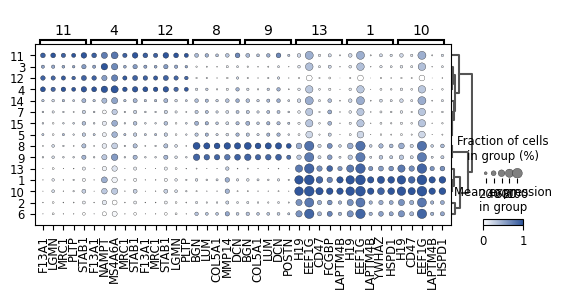

In [55]:
fig, ax = plt.subplots(figsize=(6.3, 2.8)) #8,3
dp = sc.pl.rank_genes_groups_dotplot(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    standard_scale="var",
    n_genes=5,
    cmap=custom_cmap_blue,
    ax=ax,
    min_logfoldchange=1.5,
    groups=groups_to_plot,
    dendrogram=True,
    return_fig=True,
)
dp.style(largest_dot=50)
dp.show()
fig.tight_layout()
fig.savefig(f'{out_dir}Fig_2i.pdf')